# Ligand-Receptor Analysis

We will use "CellChat" to explore which signaling pathways might be active by searching for the concurrent gene expression of ligands and their respective receptors.
This approach can also show which cell clusters (specific cell types or cell states) may communicate with eachother and how.

In [ ]:
BiocManager::install("ComplexHeatmap") # required for CellChat
install.packages("remotes")
remotes::install_github("sqjin/CellChat")

In [ ]:
#### Load packages ####
library(dplyr)
library(CellChat)

In [ ]:
#### Load data ####
source(file.path(
  "..",
  "preprocessing",
  "load_and_prepare_seurat.R"
))

expression_matrix <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_umi_matrix.csv.gz"
)
metadata_path <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_cell_cluster_info.txt"
)

seu_obj <- adult_human_heart(
  expression_matrix = expression_matrix,
  metadata_path = metadata_path
)

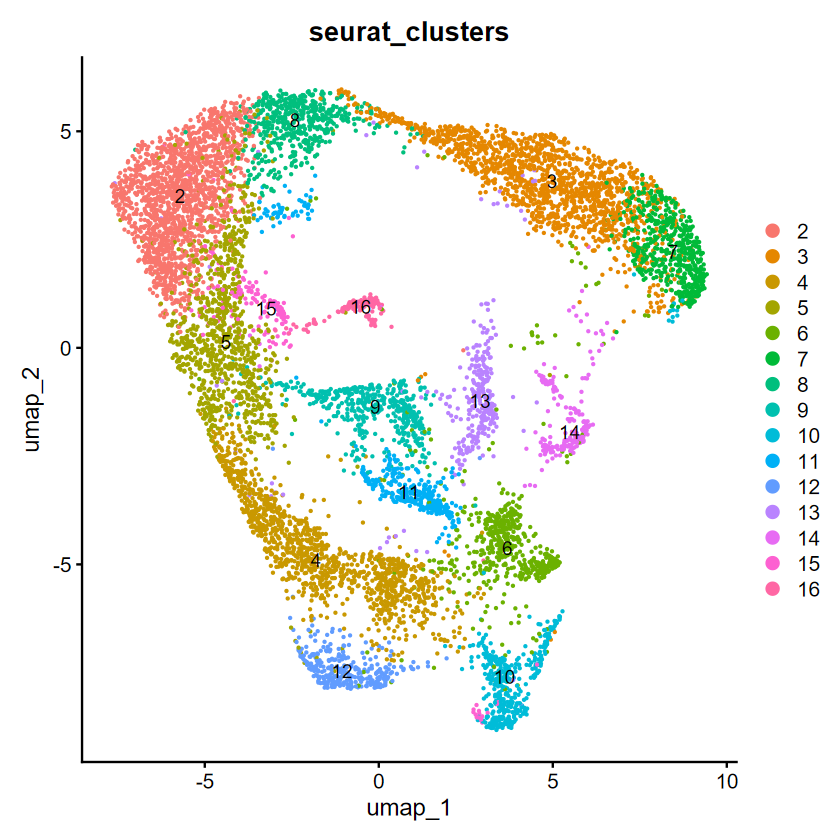

In [6]:
# Increment cluster labels by 1 because cellchat hates 0's
seu_obj$seurat_clusters <- as.factor(as.numeric(seu_obj$seurat_clusters) + 1)
# observe the cell type distribution
DimPlot(seu_obj, reduction = "umap", label = TRUE, group.by = "seurat_clusters")

In [ ]:
#### Create a CellChat object ####
cellchat <- createCellChat(object = seu_obj, group.by = "seurat_clusters")

# Set the default database (Secreted Signaling or ECM-Receptor datasets)
# there is also mouse and zebrafish databases available
# Assign the database to the CellChat object
cellchat@DB <- CellChatDB.human  # If working with human data


In [8]:
#### Identify Overexpressed Genes and Ligand-Receptor Pairs ####
# Subset expression data to overexpressed genes
cellchat <- subsetData(cellchat) # Filter out genes based on their expression
# Identify overexpressed ligands/receptors
cellchat <- identifyOverExpressedGenes(cellchat)
# Identify overexpressed interactions between cell types
cellchat <- identifyOverExpressedInteractions(cellchat)

In [ ]:
#### Calculate Communication Probabilities ####
# Calculate communication probabilities
cellchat <- computeCommunProb(cellchat)

# Filter out communications with low probabilities
cellchat <- filterCommunication(cellchat, min.cells = 10)

In [10]:
#### Infer the communication network at the pathway level ####
# Infer the communication network at the pathway level
cellchat <- computeCommunProbPathway(cellchat)
# Aggregate the inferred cell-cell communications
cellchat <- aggregateNet(cellchat)

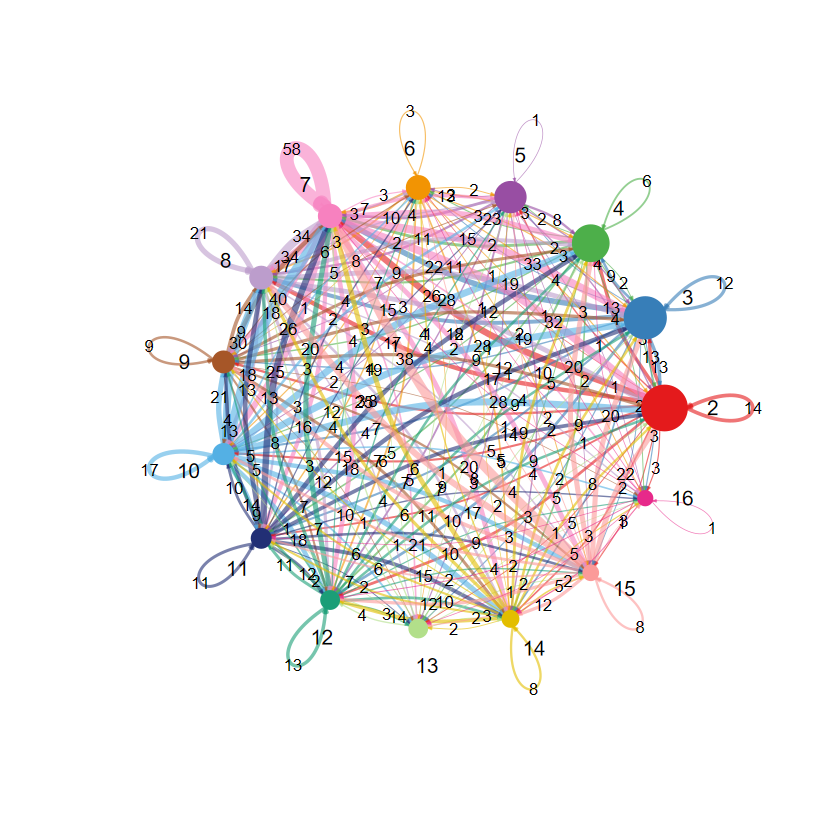

In [16]:
#### Visualize the communication network ####
# Plot the aggregated network
plot_output <- netVisual_circle(
  cellchat@net$count,
  vertex.weight = as.numeric(table(cellchat@idents)),
  weight.scale = TRUE,
  label.edge = TRUE
)

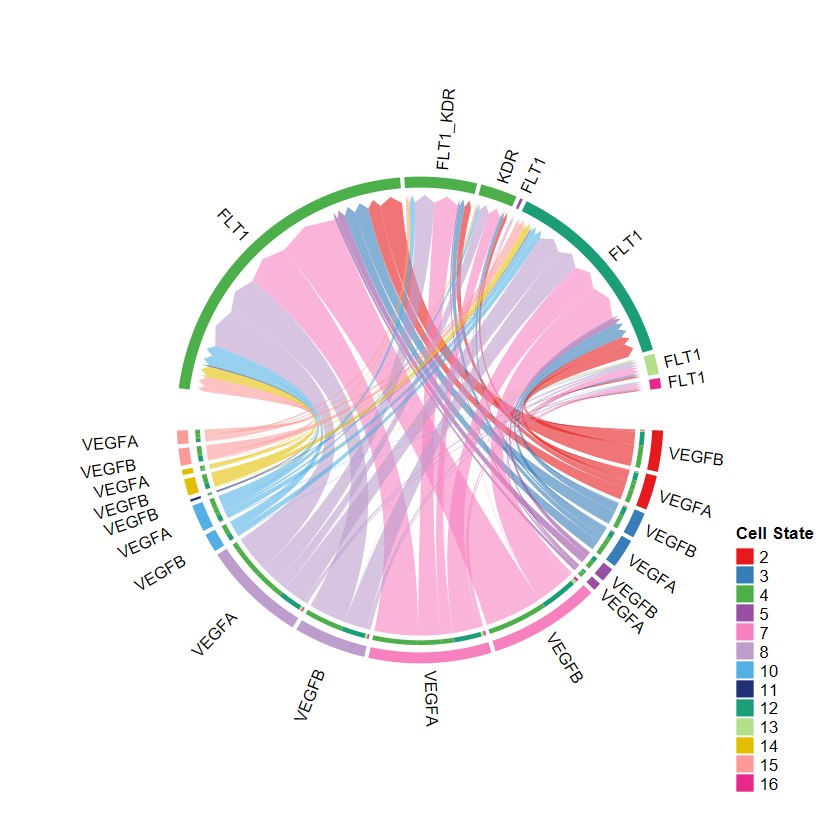

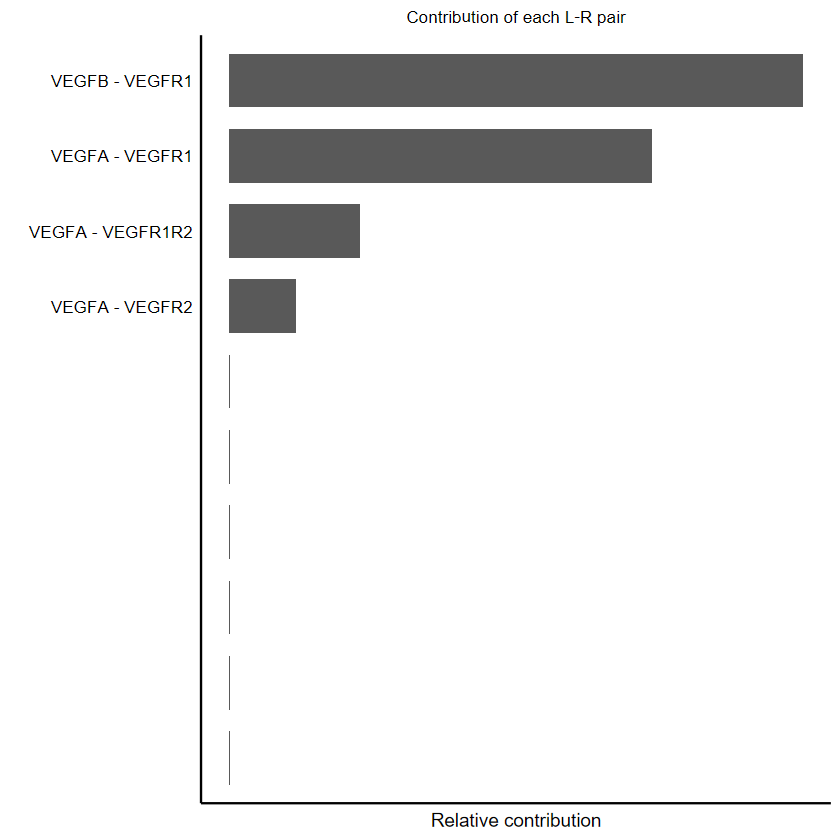

In [25]:
# Chord diagram for a specific signaling pathway, e.g., "WNT"
plot_output <- netVisual_chord_gene(
  cellchat,
  signaling = "VEGF",
  legend.pos.x = 6,
  legend.pos.y = 10
)
# Visualize contribution of ligands/receptors in a specific signaling pathway
netAnalysis_contribution(cellchat, signaling = "VEGF")


Do heatmap based on a single object 




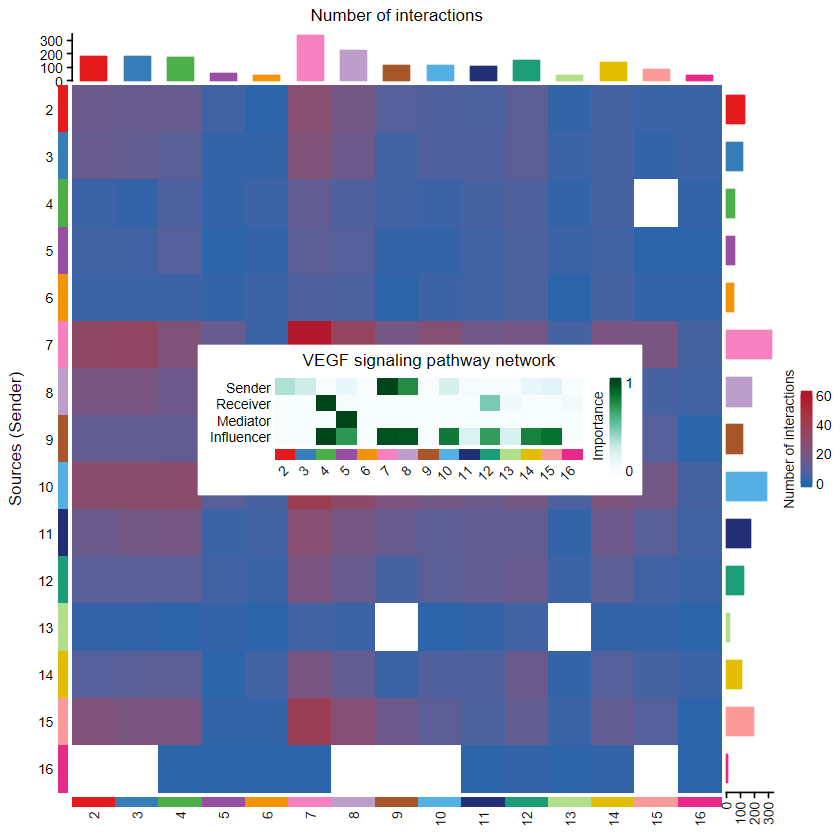

In [13]:
# Heatmap for all signaling pathways
netVisual_heatmap(cellchat)
# Hierarchical plot for a specific signaling pathway, e.g., "WNT"
cellchat <- netAnalysis_computeCentrality(
  cellchat,
  slot.name = "netP"
)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = "VEGF",
  slot.name = "netP"
)

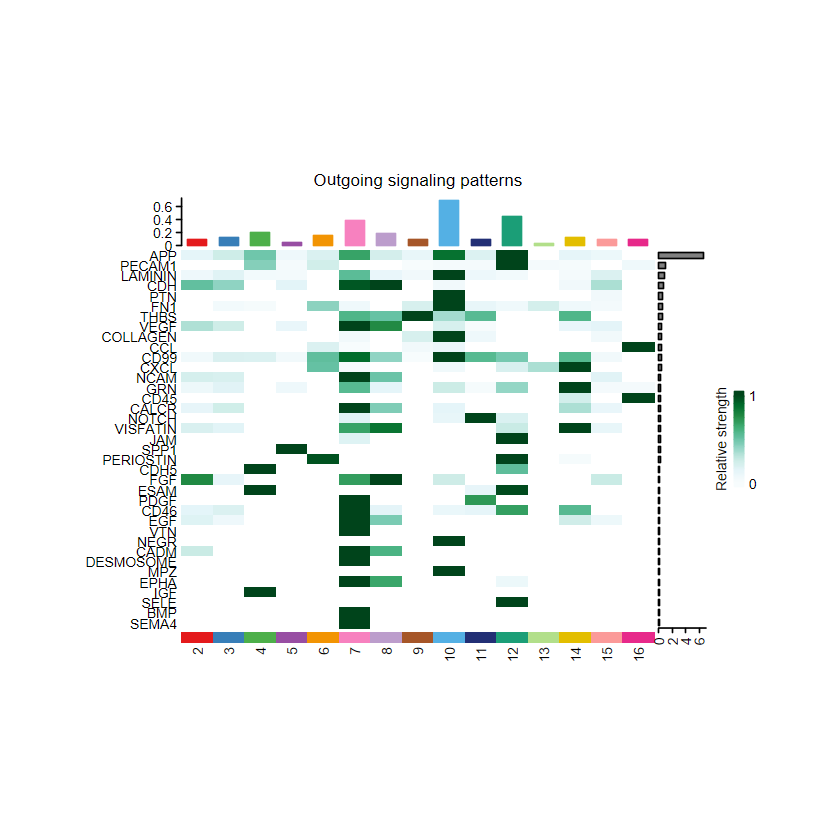

In [14]:
# Heatmap showing the role of different cell types as senders or receivers
# View both outgoing and incoming roles for VEGF pathway
netAnalysis_signalingRole_heatmap(
  cellchat,
  pattern = "outgoing"
) # For outgoing (sending)

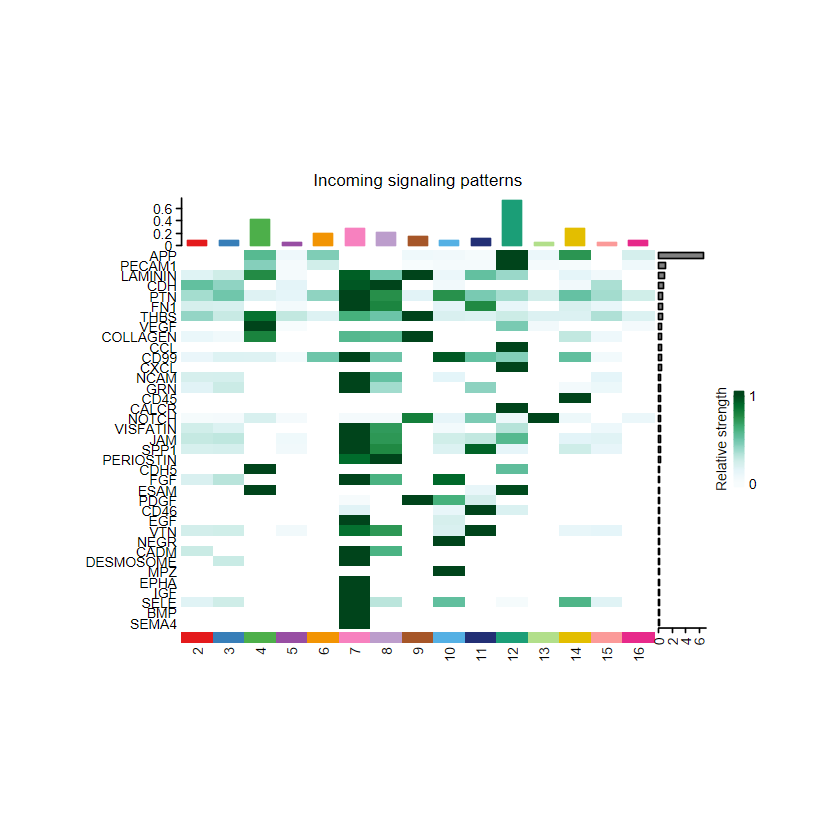

In [15]:
netAnalysis_signalingRole_heatmap(
  cellchat,
  pattern = "incoming"
) # For incoming (receiving)
